In [1]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class MinibatchDiscriminator(tf.keras.layers.Layer):
    def __init__(self, b, c):
        super(MinibatchDiscriminator, self).__init__()
        self.b = b
        self.c = c

    def build(self, input_shape):
        self.T = self.add_weight(
            shape=(input_shape[-1], self.b, self.c),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
    
    @tf.function
    def call(self, inputs):
        M = tf.tensordot(inputs, self.T, axes=[[1],[0]])
        diff = tf.expand_dims(M,0) - tf.expand_dims(M,1)
        c = tf.math.exp(-tf.norm(diff, ord=1, axis=3))
        o = tf.reduce_sum(c, axis=1)
        return tf.concat([inputs, o], 1)

     

In [3]:
a = tf.cast(tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]]), 'float')
ll = MinibatchDiscriminator(10,11)
out = ll(a)
print(out.shape)

(5, 12)


In [4]:
class AAE:
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size):
        super(AAE, self).__init__()
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        self.latent_dim = latent_dim
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.ae_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            #tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            #tf.keras.layers.Conv2D(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            #tf.keras.layers.InputLayer(input_shape=latent_dim),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(dense_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[2]/self.stride_reduction**2), activation='relu'),
            tf.keras.layers.Reshape((int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), filters[2])),
            #tf.keras.layers.Conv2DTranspose(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            #tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same'),
        ])

        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(discriminator_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            #MinibatchDiscriminator(minidc_dims[0,0], minidc_dims[0,1]),
            tf.keras.layers.Dense(discriminator_units[1], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            #MinibatchDiscriminator(minidc_dims[1,0], minidc_dims[1,1]),
            #tf.keras.layers.Dense(discriminator_units[2], activation='relu'),
            #tf.keras.layers.Dropout(keep_prob),
            tf.keras.layers.Dense(1),
        ])
    
    def sample(self, n_samples, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    @tf.function
    def encode(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return mean, log_var

    @tf.function
    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * .5) + mean
    
    @tf.function
    def encode_and_reparametrize(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return self.reparametrize(mean, log_var)

    @tf.function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def autoencoder_loss(self, X, training=False):
        # Generate latent space vector by encoding X
        mean_generated, log_var_generated = self.encode(X, training=training)
        z_generated = self.reparametrize(mean_generated, log_var_generated)
        # Decode
        X_generated = self.decode(z_generated, apply_sigmoid=True, training=training)
        # Autoencoder loss
        ae_loss = tf.reduce_mean(tf.math.squared_difference(X_generated, X))
        #ae_loss = self.ae_cross_entropy(y_true=X, y_pred=X_generated)
        return ae_loss
    
    @tf.function
    def generator_loss(self, fake_output, training=False):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def discriminator_loss(self, real_output, fake_output, training=False):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def train_step(self, batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, training=True)
    
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        # Discriminator
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)
            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake, training=True)
            # Discriminator Acc
            dc_acc = self.dc_accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)
            # Generator loss
            gen_loss = self.generator_loss(dc_fake, training=True)

        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        return ae_loss, dc_loss, dc_acc, gen_loss
    
    def fit(self, train_dataset, epochs):
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()
        ae_loss_history = []
        dc_loss_history = []
        gen_loss_history = []
        global_step = 0
        ae_loss = 0
        dc_loss = 0
        dc_acc = 0
        gen_loss = 0
        for epoch in range(epochs):
            if epoch in [25, 50, 75, 100, 125, 150, 175, 200]:
                self.base_lr = self.base_lr / 2
                self.max_lr = self.max_lr / 2
                self.step_size = self.step_size / 2
            epoch_start = dt.now()
            for train_x in train_dataset:
            #    global_step = global_step + 1
            #    cycle = np.floor(1 + global_step / (2 * self.step_size))
            #    x_lr = np.abs(global_step / self.step_size - 2 * cycle + 1)
            #    clr = self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.learning_rate = base_lr
                self.dc_optimizer.learning_rate = base_lr
                self.gen_optimizer.learning_rate = base_lr
                ae_loss, dc_loss, dc_acc, gen_loss = self.train_step(train_x)
                ae_loss_history.append(ae_loss)
                dc_loss_history.append(dc_loss)
                gen_loss_history.append(gen_loss)
        
            epoch_end = dt.now()
            print("Epoch: {}, time elapsed: {}, AE loss: {}, Discriminator loss: {}, Discriminator accuracy: {}, Generator loss: {}".format(epoch + 1, epoch_end - epoch_start, ae_loss, dc_loss, dc_acc, gen_loss))
        
        return ae_loss_history, dc_loss_history, gen_loss_history


In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [6]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 200

latent_dim = 128
alpha_leaky = 0.1
filters = [64,128,256]
kernel_size = [4,4,4]
strides = [2,2,2]
dense_units = [500,300]
discriminator_units = [400,200]
keep_prob = 0.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size)
ae_loss_history, dc_loss_history, gen_loss_history = aae.fit(train_dataset, epochs=epochs)

Epoch: 1, time elapsed: 0:02:46.632795, AE loss: 0.029119372367858887, Discriminator loss: 1.390493392944336, Discriminator accuracy: 0.5471199750900269, Generator loss: 0.6933833956718445
Epoch: 2, time elapsed: 0:03:33.251067, AE loss: 0.021281126886606216, Discriminator loss: 1.3867697715759277, Discriminator accuracy: 0.5236849784851074, Generator loss: 0.6932589411735535
Epoch: 3, time elapsed: 0:03:36.550248, AE loss: 0.016830600798130035, Discriminator loss: 1.3863334655761719, Discriminator accuracy: 0.5157899856567383, Generator loss: 0.6931571364402771
Epoch: 4, time elapsed: 0:03:48.769438, AE loss: 0.011242995969951153, Discriminator loss: 1.3862948417663574, Discriminator accuracy: 0.5118424892425537, Generator loss: 0.6931473016738892
Epoch: 5, time elapsed: 0:03:48.964083, AE loss: 0.010213827714323997, Discriminator loss: 1.3862943649291992, Discriminator accuracy: 0.509473979473114, Generator loss: 0.6931471228599548
Epoch: 6, time elapsed: 0:03:49.349045, AE loss: 0.0

Text(0, 0.5, 'BinCE')

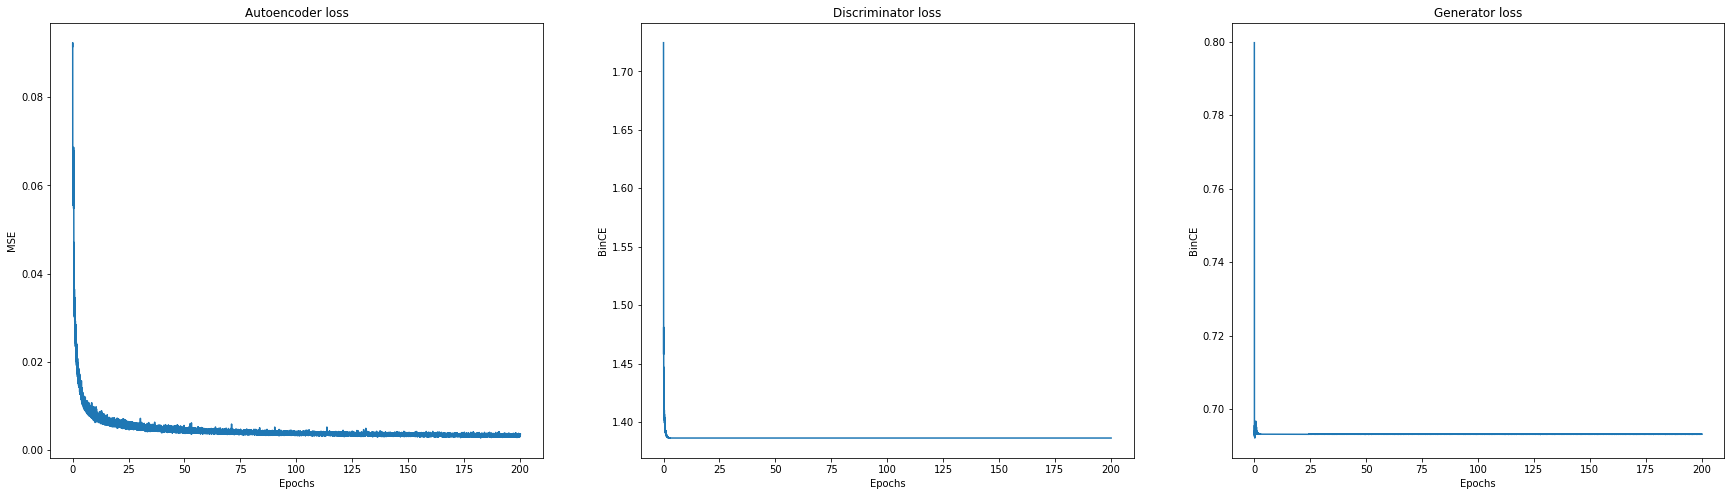

In [7]:
steps_per_epoch = train_images.shape[0] / batch_size

F, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].plot((np.arange(len(ae_loss_history))+1)/steps_per_epoch, ae_loss_history)
ax[0].set_title('Autoencoder loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE')
ax[1].plot((np.arange(len(dc_loss_history))+1)/steps_per_epoch, dc_loss_history)
ax[1].set_title('Discriminator loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('BinCE')
ax[2].plot((np.arange(len(gen_loss_history))+1)/steps_per_epoch, gen_loss_history)
ax[2].set_title('Generator loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('BinCE')


In [8]:
aae.encoder.save('enc_model')
aae.decoder.save('dec_model')
aae.discriminator.save('dc_model')

INFO:tensorflow:Assets written to: enc_model\assets
INFO:tensorflow:Assets written to: dec_model\assets
INFO:tensorflow:Assets written to: dc_model\assets


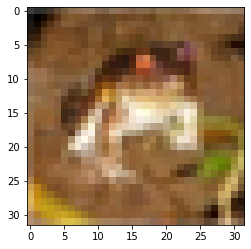

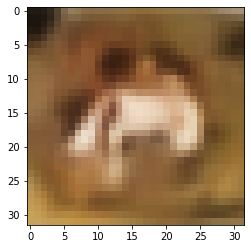

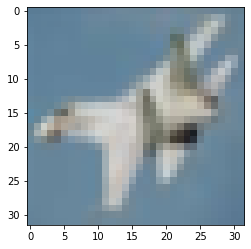

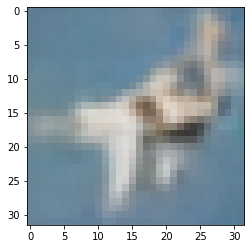

In [16]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()


In [21]:
# Faccio il test error per batch perché sul mio PC la GPU va OOM
test_errors = []
for x_batch in test_dataset:
    test_err = aae.autoencoder_loss(x_batch)
    test_errors.append(test_err)
test_err = np.mean(test_errors)
print(test_err)

0.0051065003


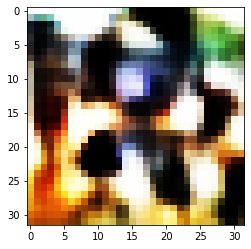

In [36]:
import tensorflow_probability as tfp

z = np.random.randn(1,128)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()

In [45]:
X = train_images[5].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(X)
print(z)
vote = aae.discriminator(z)
print(vote)

tf.Tensor(
[[ -9.180983    -0.35027286  -4.612308   -23.638357    -1.5534941
  -16.653355   -18.598955    36.180744   -16.483582   -20.42311
   -1.6066233   -9.844762    -2.0021386   13.818407    -2.5639904
   -6.133551    -5.5354366    4.3171086   -5.257024    -4.208392
   10.235378   -11.34755     -1.6448117  -15.478499     4.6321435
    7.4817867   -2.6240094    1.6879623    2.6136928   -7.1038394
  -14.089923    -3.1544468   -3.005879    -9.277569     8.663055
    8.184719    -0.6353431    8.232112    23.581017   -20.940853
   -2.22881     -6.6832128   18.804222    25.076817    -7.7648196
   29.825682    21.52448     -6.3674345   -7.4598856    3.3832908
   -8.370995     3.451772   -18.734203    14.247446    14.675109
  -12.65297     14.202738     7.2345676  -31.766462    19.350178
   21.96871    -12.532799   -17.494402   -13.52986     -6.037249
   -0.5603142    4.130288     8.858164     9.693582   -12.380301
  -13.077116    10.3217       9.300795   -10.67531     -5.1731243
   24.04

In [ ]:
import tensorflow as tf
a = 2
b = 3
c = 4
f_x = tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]])
print(f_x.shape)
T = tf.constant([[[1,1,1,1],[2,2,2,2],[3,3,3,3]],[[4,4,4,4],[5,5,5,5],[6,6,6,6]]])
print(T.shape)
M = tf.tensordot(f_x, T, axes=[[1],[0]])
print(M.shape)
diff = tf.expand_dims(M, 0) - tf.expand_dims(M,1)
print(diff.shape)
c = tf.norm(diff, ord=1, axis=3)
c = tf.cast(c, 'float')
c = tf.math.exp(-c)
print(c.shape)
o = tf.reduce_sum(c, axis=1)
print(o.shape)



(5, 2)
(2, 3, 4)
(5, 3, 4)
(5, 5, 3, 4)
(5, 5, 3)
(5, 3)
